In [1]:
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
import cv2

from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils

from keras.models import load_model
import argparse
from PIL import Image
import matplotlib.pyplot as plt


### Initialize directory path variable and describe a function to process and store video frames:

In [4]:
store_image=[]
train_path = './Train_2'
fps=5
train_videos=os.listdir(train_path)
train_images_path=train_path+'/frames'
os.makedirs(train_images_path)



In [2]:
def store_inarray(image_path):
    image=load_img(image_path)
    image=img_to_array(image)
    image=cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
    gray=0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]
    store_image.append(gray)
    


### Extract frames from video and call store function:

In [3]:
for video in train_videos:
    os.system( 'ffmpeg -i {}/{} -r 1/{}  {}/frames/{}-%02d.jpg'.format(train_path,video,fps,train_path,video)) #extract frame from video by ffmpeg
    images=os.listdir(train_images_path)
    for image in images:
        image_path=train_images_path + '/' + image
        store_inarray(image_path)

In [6]:
store_image

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.02628234, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.47950688, 0.51972157,
         0.51813924],
        [0.        , 0.        , 0.        , ..., 0.2989    , 0.3840319 ,
         0.35798407],
        [0.        , 0.        , 0.        , ..., 0.2989    , 0.2989    ,
         0.2989    ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        

### Store the store_image list in a numpy file “training.npy”:

In [7]:
store_image=np.array(store_image)
#store_image=np.array(store_image,dtype='uint8') #if size of data-set is big: use this line to reduce size
a,b,c=store_image.shape

store_image.resize(b,c,a)
store_image=(store_image-store_image.mean())/(store_image.std())
store_image=np.clip(store_image,0,1)
np.save('training.npy',store_image)

### Create spatial autoencoder architecture:

In [7]:
stae_model=Sequential()
stae_model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
stae_model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.5,recurrent_dropout=0.3,return_sequences=True))
#stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.5,recurrent_dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.5,return_sequences=True))
#stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))


In [8]:
stae_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 55, 55, 10, 128)   15616     
                                                                 
 conv3d_3 (Conv3D)           (None, 26, 26, 10, 64)    204864    
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 26, 26, 10, 64)    295168    
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
                                                                 
 conv3d_transpose_2 (Conv3DT  (None, 55, 55, 10, 128)  204928    
 ranspose)                                                       
                                                      

In [9]:
stae_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

### Train the autoencoder on the “training.npy” file and save the model with name “saved_model.h5”:

In [11]:
training_data=np.load('training_2.npy')
frames=training_data.shape[2]
frames=frames-frames%10
"""________________________________________________________________________"""
training_data=training_data[:,:,:frames]
training_data=training_data.reshape(-1,227,227,10)
training_data=np.expand_dims(training_data,axis=4)
target_data=training_data.copy()
"""________________________________________________________________________"""
epochs=100
batch_size=10
"""________________________________________________________________________"""
callback_save = ModelCheckpoint("saved_model.h5", monitor="mean_squared_error", save_best_only=True)
"""________________________________________________________________________"""
#callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
"""________________________________________________________________________"""
history = stae_model.fit(training_data,target_data, batch_size=batch_size, epochs=epochs)
stae_model.save("saved_model_2.h5")

Epoch 1/100
41/41 [==============================] - 31s 748ms/step - loss: 0.1274 - accuracy: 0.5547
Epoch 2/100
41/41 [==============================] - 31s 762ms/step - loss: 0.1254 - accuracy: 0.5571
Epoch 3/100
41/41 [==============================] - 31s 752ms/step - loss: 0.1200 - accuracy: 0.5645
Epoch 4/100
41/41 [==============================] - 31s 761ms/step - loss: 0.1067 - accuracy: 0.5833
Epoch 5/100
41/41 [==============================] - 31s 758ms/step - loss: 0.1000 - accuracy: 0.5907
Epoch 6/100
41/41 [==============================] - 31s 748ms/step - loss: 0.0953 - accuracy: 0.5971
Epoch 7/100
41/41 [==============================] - 31s 747ms/step - loss: 0.0931 - accuracy: 0.5997
Epoch 8/100
41/41 [==============================] - 31s 763ms/step - loss: 0.0896 - accuracy: 0.6043
Epoch 9/100
41/41 [==============================] - 30s 741ms/step - loss: 0.0868 - accuracy: 0.6078
Epoch 10/100
41/41 [==============================] - 30s 743ms/step - loss: 0.086

### Loss & Accuracy Plot

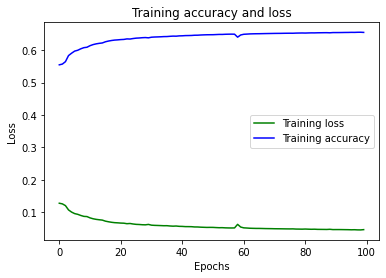

In [12]:
loss_train = history.history['loss']
acc_train = history.history['accuracy']
epochs = range(1,6)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(acc_train, 'b', label='Training accuracy')
plt.title('Training accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### For TEST: Use test.py file